# Bitcoin prediction - Artificial Intelligence Exam Summer 2019
## Time series prediction using:
* Autoregressive Integrated Moving Average (ARIMA)
* Recurrent Neural Networks and Long-Short Term Memory

Bitcoin is the largest cryptocurrency in the world. It is a digital currency without need of a central bank or administrator. It is purely based off the peer-to-peer network. Since 2013 the Bitcoin price has been doubled by a 1000. The price is now around 9000 USD.

In this notebook we will investigate wether it is possible to predict future Bitcoin prices based on time series data.
The dataset is from [CryptoCompare](https://www.cryptocompare.com/).



In [3]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import requests
import json

# Pandas - data analysis library.
import pandas as pd
from pandas import Series

# Sklearn - supervised and unsupervised learning algorithm library.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Keras - neural-network library running on top of Tensorflow.
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import LSTM
#from keras.layers import CuDNNLSTM
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import ConvLSTM2D
from keras.layers import Dropout

# Matplot library - interface for plotting.
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Loading data from the Bitcoin API

In [4]:
# Get request to the API.
# The data is from today and 2000 days in the past. The price i calculated in USD.
request = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
# Loading the data from the API, which is in JSON format, into a DataFrame.
hist = pd.DataFrame(json.loads(request.content)['Data'])
# Setting the index of the dataframe to the coloum 'time'.
hist = hist.set_index('time')
# Converting the time coloum from UNIX timestamp to regular time format.
hist.index = pd.to_datetime(hist.index, unit='s')
# Creating a new coloum from the mean value of close, high, low and open.
hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4
hist.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8785.17,8931.53,8668.46,8726.23,57692.17,5.071647e+08,8777.8475
2019-05-28,8697.58,8818.71,8562.20,8785.17,36051.50,3.138563e+08,8715.9150


In [5]:
# Creating a new array containing the mean of each month
month_hist = hist['Weighted_Price'].resample('MS').mean()
month_hist.tail()
month_hist = month_hist['2016':]

In [6]:
# Checking if there is any zero values in our dataset.
print(f'NaN values: \n\n{hist.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


## Bitcoin graph

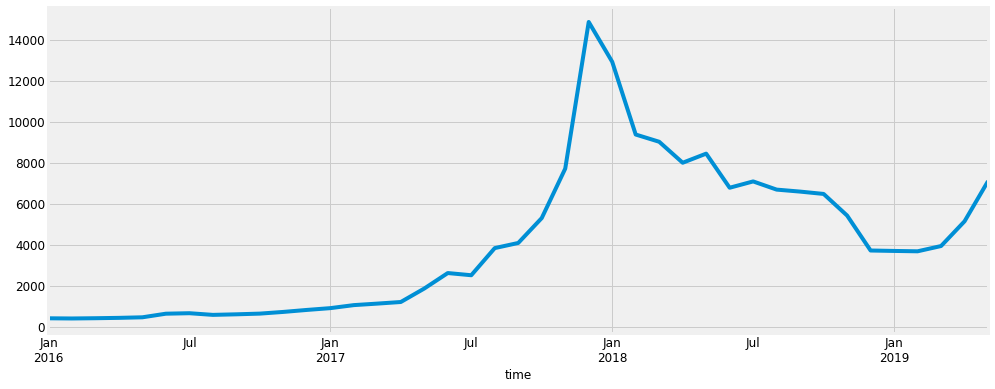

In [7]:
# Plotting the price over time i months.
month_hist.plot(figsize=(15,6))
plt.show()

---

# ARIMA prediction
ARIMA model is a statistical model for analyzing and forecasting time series data.

* Auto Regression tries to fit a line based on previous values. This is the 'p' in the ARIMA p-d-q formular. This value is setting how many months backwards we want to use to predict 1 month forward.

* Integrated making the data stationary. This is the 'd' in the ARIMA p-d-q formular. The data must be stationary in order to work with it in the SARIMA model. Stationary is, the mean variance should be constant.

* Moving Average is 



Skal vi skrive lidt tekst om hvad ARIMA er og hvad vi tager højde for i denne model?
Måske det om vi bruger seasonal?
Hvordan ser formlen ud?

desuden sagde hun der vigtigste var billede illustrationer. måske vi skal finde noget ift arima men også rnn lstm.
fx. til lstm kan vi tegne det som hun tegnede for os i dag når man forudsiger lstm

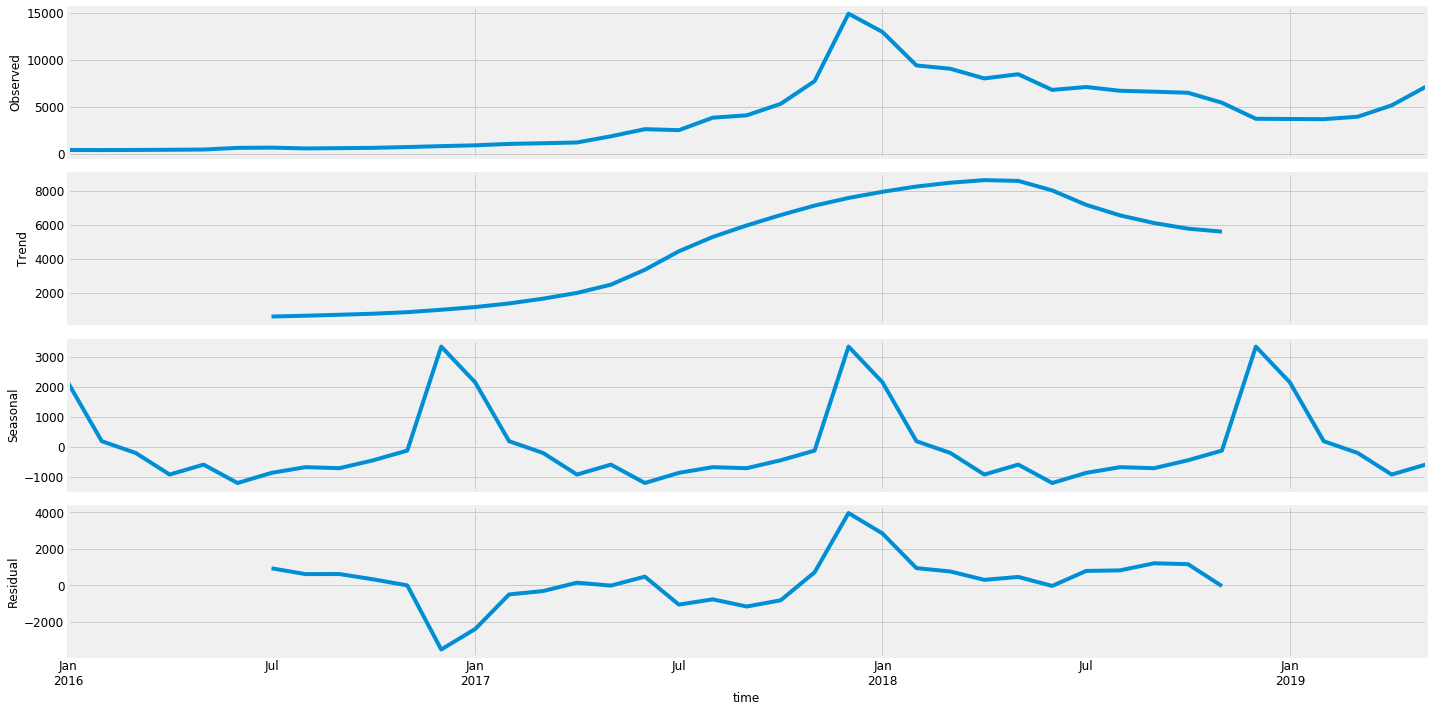

In [8]:
rcParams['figure.figsize'] = 20, 10

# Decomposing to visualize and identify trend, seasonality and residual.
# The graphs shows a opward going trend in the bitcoin market late 2016.
# There is a possible seasonality pattern at the end of the year with a big increase in price with a following decrease.
# Residual is noise. This is what there is left when removing trend and seasonal from the observed graph.
decomposition = sm.tsa.seasonal_decompose(month_hist, model='additive')
fig = decomposition.plot()
plt.show()

In [9]:
# ARIMA model (seasonal ARIMA, SARIMA)
# 'p' is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
# 'd' is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
# 'q' is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
# These are the three integers (p, d, q) that are used to parametrize ARIMA models.
p = d = q = range(0, 3)

# pdq is an array of tuples. 
# Generating 2 arrays of tuples with examples of parameter combinations bewtween (0-1).
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [10]:
# We are trying to find the combination with the lowest AIC(an estimator to realative quaility of statistical models for a given set of data).
for param in pdq:
    for param_seasonal in seasonal_pdq:
        # Try since not all combinations makes sense, some will throw an error.
        try:
            # Using Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model(SARIMAX).
            # eXogenous argument is not given, which makes it a SARIMA model.
            model = sm.tsa.statespace.SARIMAX(month_hist,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        # If we come across an invalid combination, just skip it and continue.
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:805.1859721066073
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1155.0689096175365
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:568.6390201215552
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:344.94257784486877
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:586.3326794056612


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:570.7173811760886
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:346.00990649740413
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:85.52964719979002
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:338.40012562428626


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:340.6951165276959
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:79.57239373457392
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:743.0162466945943
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2579.9202096489794
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:531.3515648831401
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:314.9039806178072
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:558.4156285768572
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:524.1648974640271
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:325.8427099577166
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:84.85930003164476
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:317.9577835810533
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:317.7718705477997


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:79.07911223445228
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:703.6817410660817
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:2291.2971962874226
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:507.7070362040906
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:294.85955717776216
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:545.7990978715428
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:494.4983176978017
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:316.8533602162683


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:87.20562895337589
ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:309.86400910972435


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:313.79771569040133


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:90.16847712196935
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:684.9063937036482
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1193.984066079786
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:506.315090093649
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:301.0417218471963
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:502.46305767659175
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:487.1960617070864
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:274.7481318825107
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:65.89638890809977
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:276.55671749304616
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:277.65167776306293
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:67.86157731624158
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:668.2038968604254
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2406.1754859356774
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:488.76230332762077
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:283.12525959578034
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:502.9867421931628
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:470.70950887417484
ARIM

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:66.47728500544692
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:653.4083285447513
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:2164.8423394612696
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:473.38829622605726
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:266.8198437872637
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:504.81880428046384
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:455.85397948095044
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:276.1226501614917


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:69.32414276899146
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:276.29143112040776


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:271.36912621402934


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:69.80602375457133
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:685.060608236026
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:930.8244173867905
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:499.60790670783365
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:288.11077647816177
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:497.88818385000445


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:1117.0703981787385
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:261.2188192724045
ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:52.83027913229539
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:262.90319317562046
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:698.5135019015735
ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:52.67075631546246
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:656.8064280727943
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:2156.6430012822825
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:474.4507018349053
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:266.3293503223833
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:488.95860065171195
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:1978.9557769745225
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:251.1743371885098
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:55.1743292693221
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:251.47442791666754
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:667.712140292271


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:50.11692611922488
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:640.2954613194498
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:457.90873513873464
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:249.08723377250692
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:489.65147718542545
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:2010.3736848475428
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:253.15430342409334
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:67.06958278232788
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:253.4172858234914


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:643.7135766640821


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:61.54385364687184
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:703.245273101043
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1320.7352819421271
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:524.5396960171511
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:321.3208823799657
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:506.06577129473
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:506.36785760425323
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:271.5944432602025
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:67.2270277231103
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:268.91284796014526


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:270.0362695682719
ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:78.42134363254978
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:686.2742602731869
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1915164.0004930124
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:506.19209700571196
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:302.7502750476139
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:505.8778071141681
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:489.6355475053325
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:263.6283726172252


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:69.92145048116362


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:270.4342738008638
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:279.5460480374045


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:67.20769147444116
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:671.6361972233912
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:2141.2747188820135
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:491.04362629287687
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:286.6628847871884
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:506.9430028669956
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:474.7783397682894
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:295.063497916647


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:71.74706958608617


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:268.3436522690522


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:274.6038797528217


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:83.07164366630315
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:685.1821153083384
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1412.108351547212
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:506.8116071176993
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:302.1757202852901
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:486.6133398395153
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:488.36188595590437
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:247.28458308518
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:49.44499446047707
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:248.9573136241714
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:249.46756932454414


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:20.684649141196076
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:670.0627821457167
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2385.776210761056
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:490.6662806596574
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:285.0521984012983
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:487.6556425968762
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:472.58605267800584
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:248.49714063734828


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:50.48710677181594
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:248.333426376914


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:248.28664549342284


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:35.684788115036945
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:655.5737417785998
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:2196.726201637175
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:474.5142693522437
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:268.44692361552507
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:489.0149081671726
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:457.1166832429033
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:245.85035901153395


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:42.278537862645905
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:247.88471024536423


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:252.48910559215452


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:36.47388190128242
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:683.5322603331819
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:1233.8327576124534
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:499.32876963138744
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:288.7916256765389
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:480.19835345379033
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:896.1158247499965

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:233.24279293624602
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:44.6844963541281
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:235.1959784607538


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:585.2890474360702
ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:43.91106852844662
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:657.0746342844192
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:1961.5935538312992
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:475.75736200453593
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:267.5559541876381
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:473.2876388443097
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:2168.5787715587962


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:233.53339318421175
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:46.79929383911521
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:235.1771424908572
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:625.8646642729304


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:45.06540390640289
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:640.3700471113996
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:1994.4605901873874
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:459.8113475002921
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:250.9980064249505
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:473.8839521684708
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:nan
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:234.18939213041983


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:34.22521785252959


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:235.4911524995682


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:622.9405925827461


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:37.79506716158807
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:686.7602749726693
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1205.3215570289476
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:506.36801854250416
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:302.7991774924253
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:490.2903775097693
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:490.24344409920263
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:247.960128066576
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:64.35679417454769
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:246.39834765351543


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:253.46920884579666


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:62.51693986233278
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:688.2050967741641
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:2242.8896326248723
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:508.18459318093727
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:304.747458860324
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:491.3412442788422
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:491.4907263305536


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:248.00254670044592
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:66.74646410052824


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:250.21696658040943


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:262.00480052757945


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:64.73641693823379
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:673.8998553182566
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:8631.097070265845
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:492.4082006712731
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:287.0004563403437
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:490.84001222695645
ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:476.77998147927235


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:256.2057704467287


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:69.56777921733314


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:265.2984560006091


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:267.27101443215275
ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:67.22074421955594
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:669.6572328227314


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:942.4445682982132
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:490.47621358015346
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:284.8878555829209
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:470.9336731359146
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:472.5386986764868
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:231.36681944022695
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:45.841096607921486
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:232.88052828493107


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:234.96845758846456
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:38.327233696925894
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:671.704668440776
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:2242.506085329085
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:492.5178318339862
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:286.98784630585425
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:472.8947857917605
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:474.4294893969392
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:232.13312944667956
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:48.127946942932724
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:231.04898507644216


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:233.16158428139087


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:46.71573784673726
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:656.9814751696358
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:3666.1182990989755
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:475.483538609587
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:270.4486373255255
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:474.0239308928198
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:459.5950676060521


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:257.2432862491196
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:50.792184674303186


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:228.813326721141


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:240.6329778363112


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:49.74986368577328
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:663.9756152480305
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:1315.3019212352406
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:479.4853106891765
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:269.38815708501517
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:461.8582486522731
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:832.0953684561481
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:217.42788240409035
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:27.260627334323658
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:218.86155102905934


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:486.64825397656045
ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:27.939412433430768
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:656.9849913047669
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:1963.8740657397107
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:476.3718644513631
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:269.1438482141512
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:457.4222161765237
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:2937.252673332708
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:219.30899171160814
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:29.359062855108732


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:221.23290242455246


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:510.2510019099355
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:29.956952253820894
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:642.488631798567
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:1891.8129972158931
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:461.73291885980075
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:252.9474659445064
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:458.69264148336674
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:1903.8061143288546


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:227.67284565253672
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:31.666862715487493


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:232.25514540906332
ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:584.9711392592374
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:32.084109763690904


c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
# After trying our diffrent fits for our model, we pick the one with the lowest AIC.
# This what is supposed to make our model the most precise.
# Here we insert the order we find above.
model = sm.tsa.statespace.SARIMAX(month_hist,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[0])

                                 Statespace Model Results                                 
Dep. Variable:                     Weighted_Price   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.642
Date:                            Tue, 28 May 2019   AIC                            247.285
Time:                                    22:51:16   BIC                            249.409
Sample:                                01-01-2016   HQIC                           247.262
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         


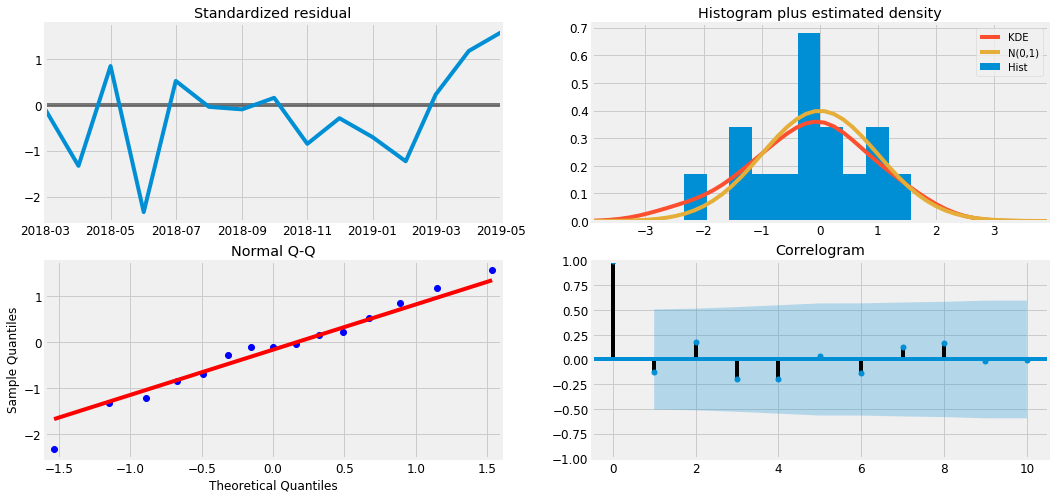

In [30]:
# Plotting model diagnostics to investigate unusual behavior.
# If the graph shows unusual behavior, it is a good sign of need for model improvement.

# Top-right shows a plot of standard notation for a normal distribution, N(0,1).
# Our model is indicated by the red line, KDE.
# This shows a overall normally distributed residuals.

# Bottom-left shows a plot of how residuals are distributed when following a trend. The red line shows a normal distribution.
# Blue dots idicate our model, which has very few outliers from the normal distribution.
# This is overall a pretty good result.

# Bottom-right shows a correlogram which plots the autocorrelation, which shows how residuals have correlation to lagged versions of itself.
# This result is not totally clear to us, so we can not draw any conclusion from it.
# However, it seems like there appear to be no correlation.

# Top-left shows residuals over time. In this case, 1 year and 2 months.
# The standardized residual seems to be white noise - it is hard to find any seasonality from the diagram.

results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Testing the model

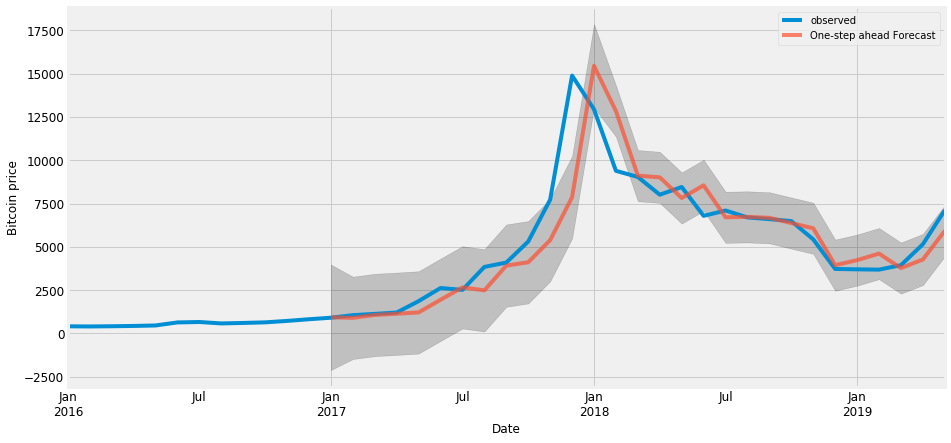

In [31]:
# Making a prediction from 1. Janurary 2017 to now, so we can compare the result with the actual observed graph.
pred = results.get_prediction(start=('2017-01-01'), dynamic=False)


# Plotting the observed graph and the 'one-step forecasting',
ax = month_hist.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts highst and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [32]:
# This is the confidence interval.
# It shows the difference between lower and upper values of predicted weighted price over time.
print(pred_ci)

            lower Weighted_Price  upper Weighted_Price
time                                                  
2017-01-01          -2112.264701           3976.908528
2017-02-01          -1479.279750           3277.100512
2017-03-01          -1311.075019           3442.785371
2017-04-01          -1240.854485           3513.003792
2017-05-01          -1162.985329           3590.872940
2017-06-01           -434.164089           4319.694180
2017-07-01            284.827453           5038.685723
2017-08-01            111.174516           4865.032785
2017-09-01           1539.383480           6293.241750
2017-10-01           1734.717602           6488.575871
2017-11-01           3010.698444           7764.556582
2017-12-01           5489.861224          10243.579545
2018-01-01          13045.661662          17867.627263
2018-02-01          11366.460604          14323.353997
2018-03-01           7638.965336          10590.127969
2018-04-01           7538.865263          10490.027896
2018-05-01

In [33]:
# Calculating the mean absolute error.
y_forecasted = pred.predicted_mean
y_truth = month_hist['2017-01-01':]

# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(y_truth, y_forecasted)
print('Mean absolute error',mae)

Mean absolute error 982.5628929721324


## Future prediction

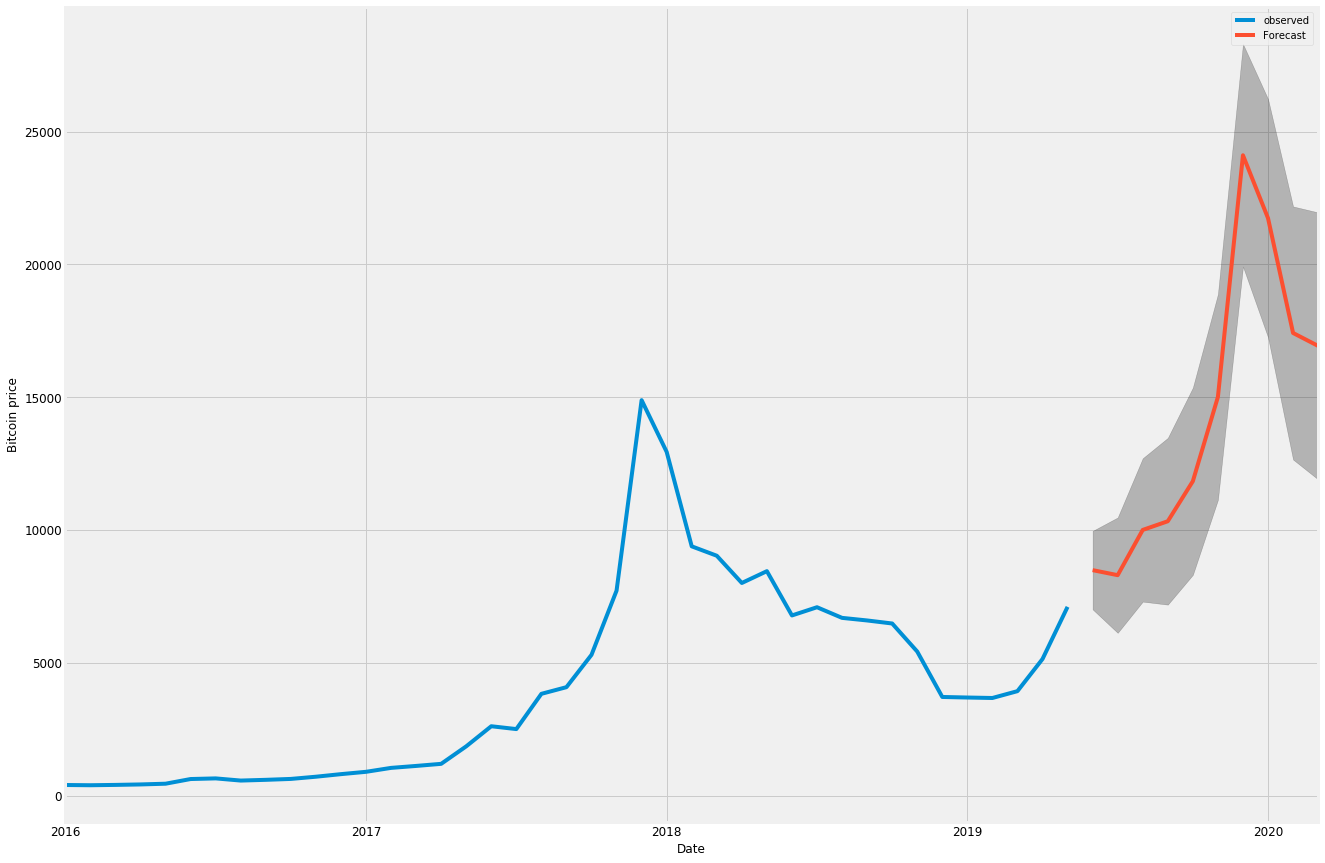

In [34]:
# We generate a forecast for the furture graph of Bitcoin.
# We call the method get_forecast which takes a parameter 'steps', as how many steps into the future do we want to forecast.
future_pred = results.get_forecast(steps=10)

# We plot the observed graph of Bitcoin prices.
ax = month_hist.plot(label='observed', figsize=(20, 15))
future_pred.predicted_mean.plot(ax=ax, label='Forecast')

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = future_pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [35]:
# Plotting the result in USD
future_pred.predicted_mean

2019-06-01     8496.421639
2019-07-01     8306.824237
2019-08-01    10009.069811
2019-09-01    10335.590072
2019-10-01    11841.538962
2019-11-01    15010.845811
2019-12-01    24107.057563
2020-01-01    21740.768180
2020-02-01    17419.905162
2020-03-01    16932.940095
Freq: MS, dtype: float64

## Conclusion
The model does seem to capture the trends and seasonality in the Bitcoin price. However, this also means that in the future it will predict the price to rise dramatically, like it did at some point in the training set.

---

# RNN LSTM Prediction
A **reccurent network** is networks with loops in them.
A loop allows information to be passed from on node in a network to another.
The image below illustrates a recurrent network. The loop to left is equal to the illustration of a loop on the right.
The network takes an input but also the output from the previous nodes as input to the current step.

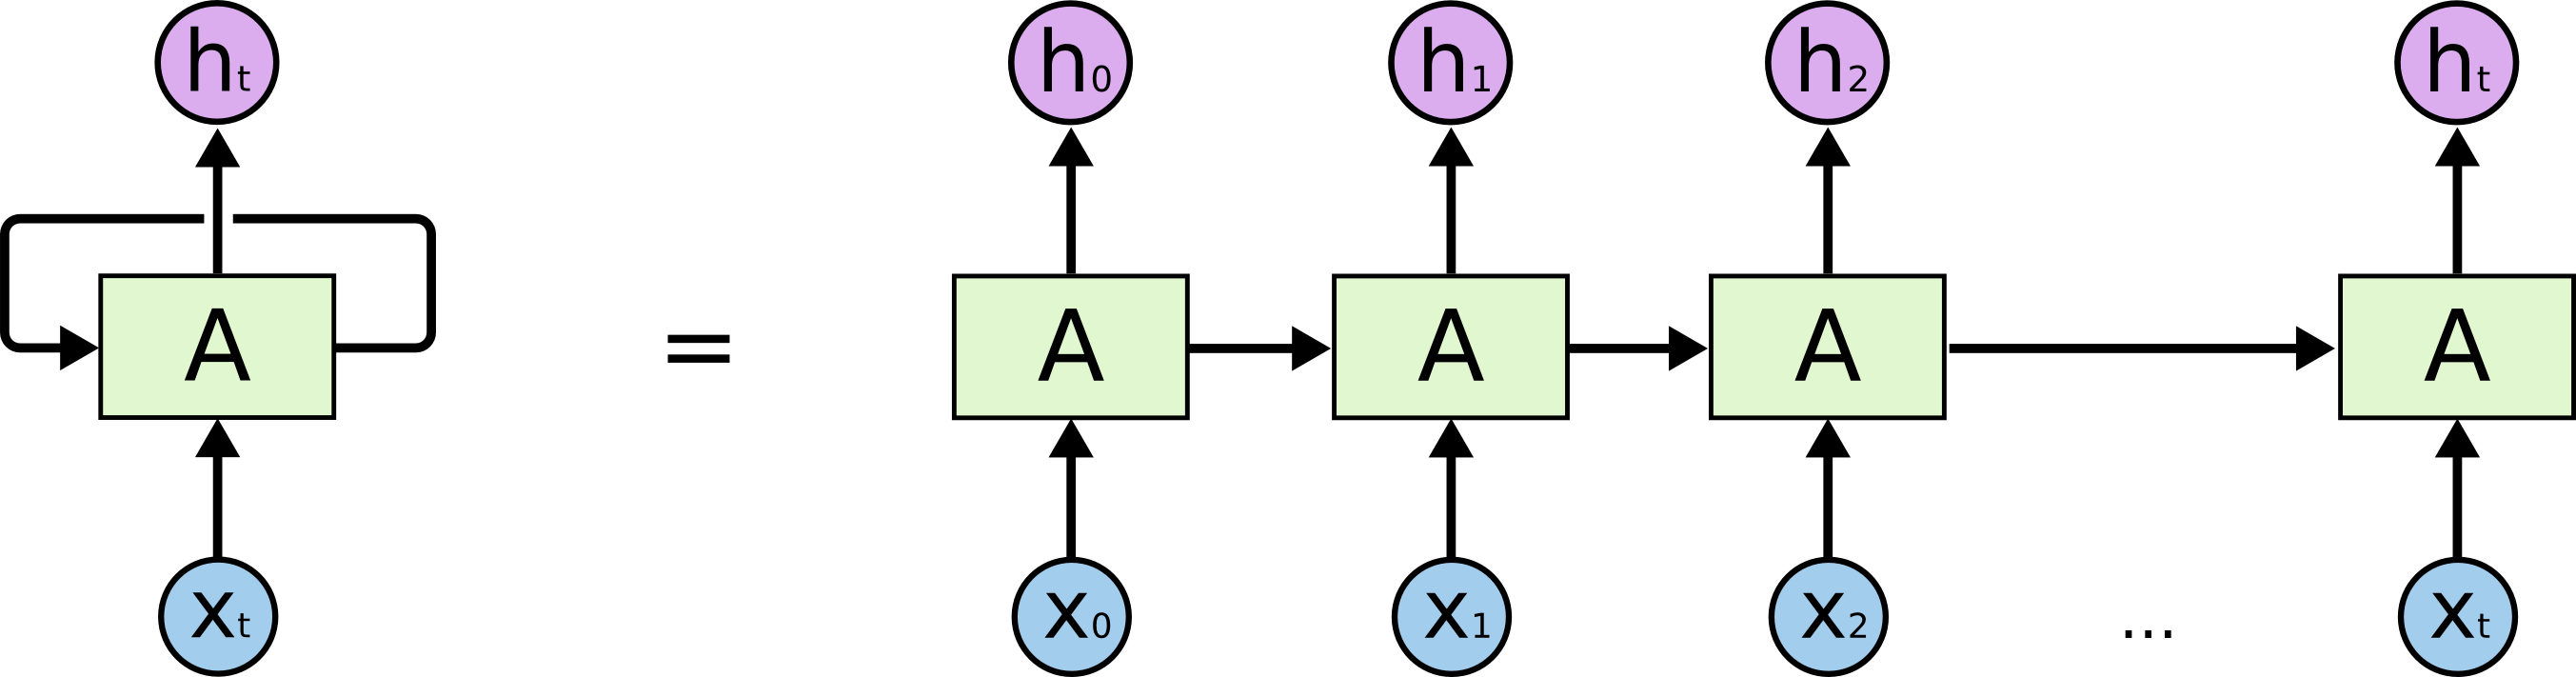


The idea behind the recurrent network is that it creates a kind of memory, which remembers all information about what has been calculated.

The **long-short term memory** comes into place as a hidden layer in the network. It's purpose is to enable RNN to remember inputs over a long period of time. The LSTM network has 3 gates. 
* Input gate, decides what is relevant to add from the current step.
* Forget gate, decides what is relevant to keep from prior steps and deletes information if it isn't important.
* Output gate, determines what the next hidden state should be.

With the above gates the model output the information to the next node & layer using Sigmoid and tanh layers.

In [36]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = hist['Weighted_Price'].values.reshape(-1,1)
print(values[0])
# Converting the values to float.
values = values.astype('float32')
# Transform values to values between 0 and 1.
# This is the type of input LSTM takes.
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1113.4375]
Length of the new datframe : 2001
[[0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]
 [0.03938658]]


In [37]:
# Divide scaled data into 80% train and 40% test with overlapping.
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))

test_size = int(len(scaled) * 0.6)
print("Test Size : " + str(len(scaled) - test_size))

train, test = scaled[:train_size,:], scaled[test_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 801
Length of training data : 1600
Length of testing data : 801


In [38]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [39]:
# Calling the create_dataset function with loop_back=1.
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1599, 1)
(1599,)
(800, 1)
(800,)


In [40]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [41]:
# Initialise the sequential model
model = Sequential()

# Add the LSTM hidden layer with 128 nodes
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))

# Adding a dropout layer of 0.2 to prevent overfitting.
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))

# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')

# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 2s 1ms/step - loss: 0.0813 - val_loss: 0.2684
Epoch 2/300
1599/1599 [==============================] - 0s 51us/step - loss: 0.0791 - val_loss: 0.2584
Epoch 3/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0751 - val_loss: 0.2515
Epoch 4/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0704 - val_loss: 0.2356
Epoch 5/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0682 - val_loss: 0.2244
Epoch 6/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0645 - val_loss: 0.2127
Epoch 7/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0607 - val_loss

1599/1599 [==============================] - 0s 47us/step - loss: 0.0072 - val_loss: 0.0109
Epoch 70/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0063 - val_loss: 0.0091
Epoch 71/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0067 - val_loss: 0.0098
Epoch 72/300
1599/1599 [==============================] - 0s 55us/step - loss: 0.0083 - val_loss: 0.0091
Epoch 73/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0083 - val_loss: 0.0096
Epoch 74/300
1599/1599 [==============================] - 0s 50us/step - loss: 0.0061 - val_loss: 0.0085
Epoch 75/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0060 - val_loss: 0.0097
Epoch 76/300
1599/1599 [==============================] - 0s 48us/step - loss: 0.0057 - val_loss: 0.0086
Epoch 77/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0064 - val_loss: 0.0086
Epoch 78/300
1599/1599 [==============================] - 0s 46us/st

1599/1599 [==============================] - 0s 47us/step - loss: 0.0053 - val_loss: 0.0088
Epoch 147/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0060 - val_loss: 0.0084
Epoch 148/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0059 - val_loss: 0.0086
Epoch 149/300
1599/1599 [==============================] - 0s 52us/step - loss: 0.0052 - val_loss: 0.0084
Epoch 150/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0056 - val_loss: 0.0088
Epoch 151/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0048 - val_loss: 0.0085
Epoch 152/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0048 - val_loss: 0.0085
Epoch 153/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0063 - val_loss: 0.0086
Epoch 154/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0052 - val_loss: 0.0087
Epoch 155/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 49us/step - loss: 0.0046 - val_loss: 0.0087
Epoch 224/300
1599/1599 [==============================] - 0s 46us/step - loss: 0.0055 - val_loss: 0.0084
Epoch 225/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0049 - val_loss: 0.0086
Epoch 226/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0048 - val_loss: 0.0083
Epoch 227/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0049 - val_loss: 0.0085
Epoch 228/300
1599/1599 [==============================] - 0s 50us/step - loss: 0.0061 - val_loss: 0.0086
Epoch 229/300
1599/1599 [==============================] - 0s 49us/step - loss: 0.0048 - val_loss: 0.0084
Epoch 230/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0057 - val_loss: 0.0084
Epoch 231/300
1599/1599 [==============================] - 0s 47us/step - loss: 0.0046 - val_loss: 0.0084
Epoch 232/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 48us/step - loss: 0.0051 - val_loss: 0.0090


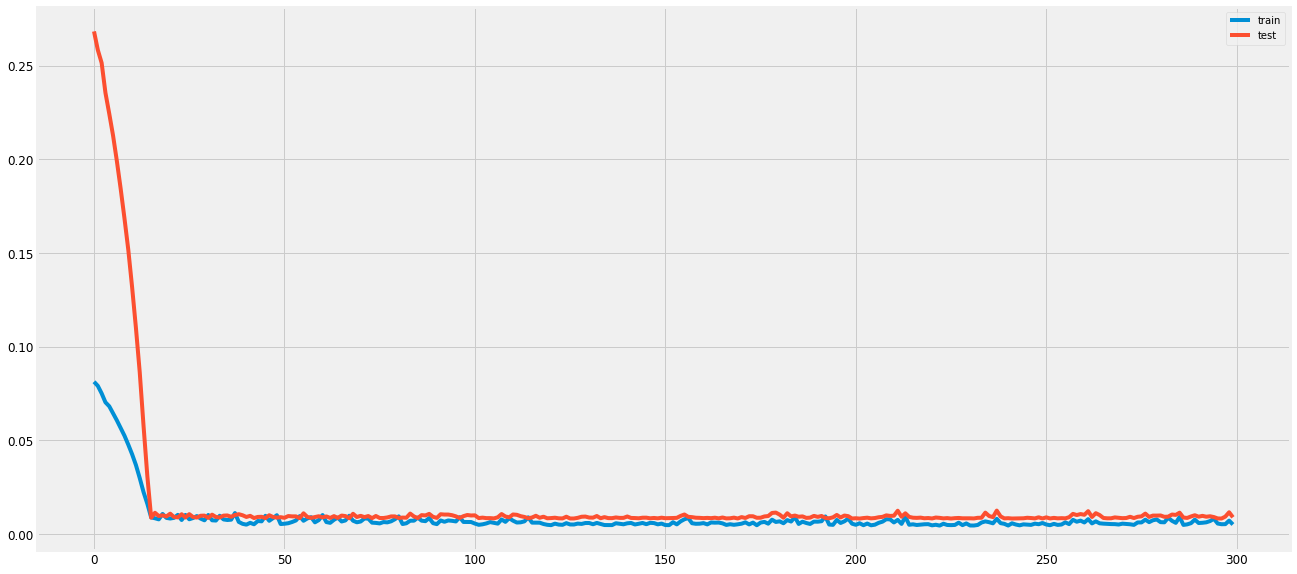

In [42]:
# Plotting the training loss vs the test validation loss.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

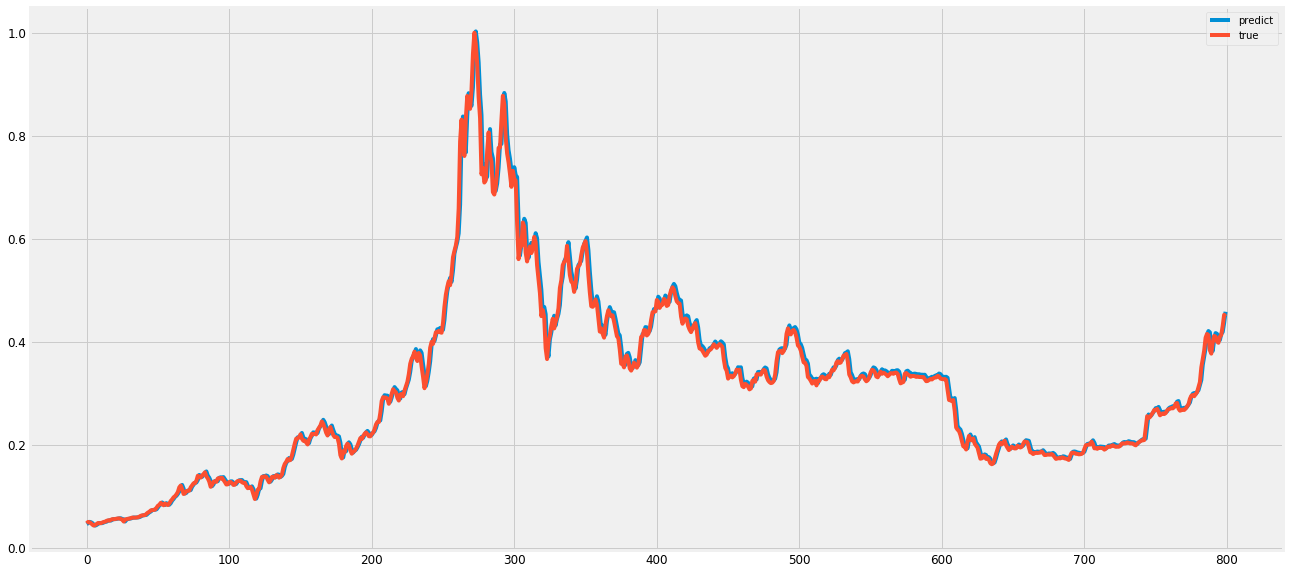

In [43]:
# We predict the values from testX.
yhat = model.predict(testX)

# Plotting the actual graph vs the predicted graph.
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [44]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1006.9751]
[1033.165]


In [45]:
# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(testY_inverse, yhat_inverse)
print('Mean absolute error',mae)

Mean absolute error 171.85925


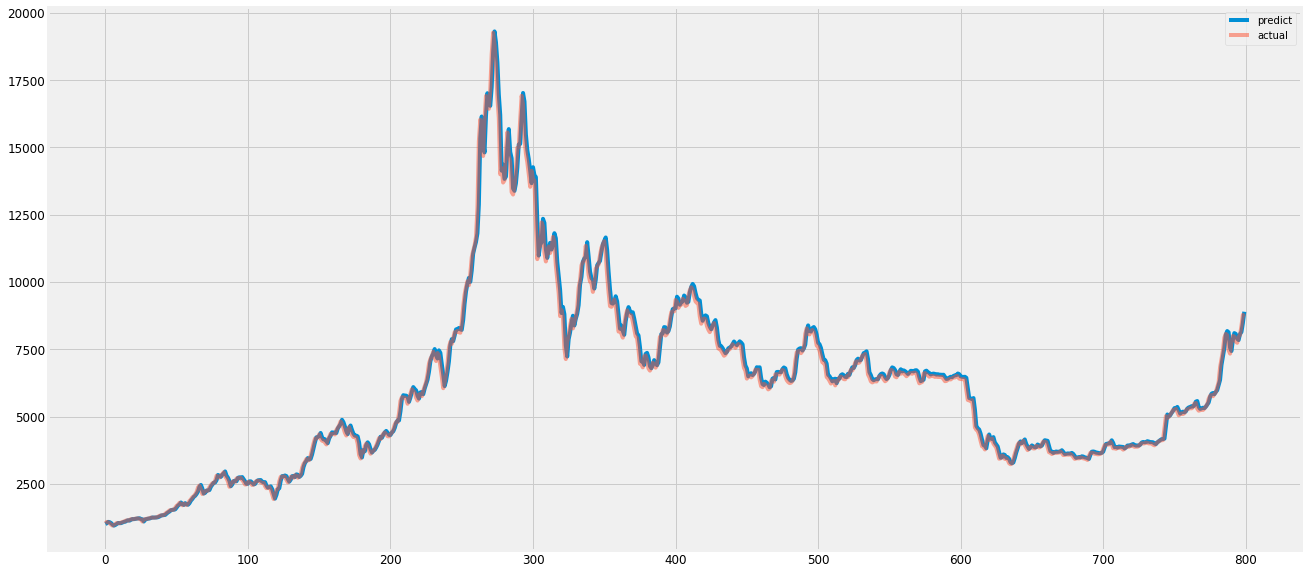

In [46]:
# Plotting prediction vs actual graph.
# This plotting shows the price.
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [47]:
# Creating a new variable containing the testX values.
# Just for good measure.
Xtest = testX

# Predicting the values from Xtest and appending the last preicted value
# to the set before predicting again
for i in range(30):
    future_preds = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    
    y = np.zeros((1,1,1))
    y[[0]] = future_preds[len(future_preds)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)

In [48]:
future_preds_inverse = scaler.inverse_transform(future_preds.reshape(-1, 1))

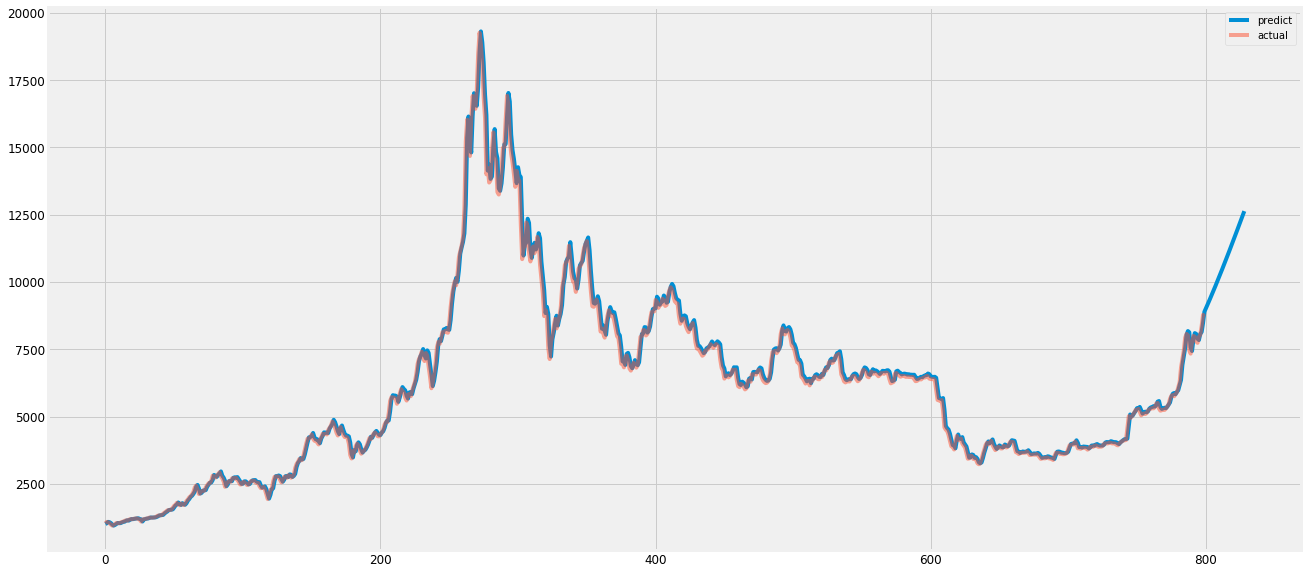

In [49]:
plt.plot(future_preds_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)

plt.legend()
plt.show()

# Refferences
* https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ (28/05/2019)
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (28/05/2019)
* https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5 (28/05/2019)

# Conclusion

By looking at the the plotted predictions compared to the actual values, and by looking at the mean absoluted error (MAE), it is very clear, that the best model on paper is our RNN LSTM model. The MAE of the SARIMA model is significantly higher than the one of the RNN LSTM model.However, the RNN LSTM model seems to have a random behaviour when predicting future values, which suggests the model is overfitted.

With this in mind we will save the SARIMA model for future predictions.

In [50]:
# Saving the model
future_pred.save('SARIMA_btc_pred.pkl')

In [51]:
from sklearn.externals import joblib
from flask import Flask, request, jsonify, render_template
import pickle

# create an instance (our app)
app = Flask(__name__)

kmmodel = joblib.load('../Data/regressor.pkl')

@app.route('/', methods=['GET', 'POST'])
@app.route('/predicted-price')
def hello(name = None):
    return render_template('start.html', name=name)
# name is parameter in the template: {{name}}

@app.route('/predict')
def predict():
    return render_template('prediction.html')

@app.route('/predicted', methods=['GET', 'POST'])
def predicted():
    if request.method == 'POST':
        x1 = request.form['x1']
        x2 = request.form['x2']
        X = [[x1, x2]]
        predicted = kmmodel.predict(X)
          
        return render_template("predicted.html", content=X, prediction=predicted)
    
@app.route('/bye')
def bye():
    return render_template('bye.html')

if __name__ == '__main__':
    app.run(debug=True)

c:\users\slask\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


ModuleNotFoundError: No module named 'flask'